In [1]:
# Upload your kaggle.json file for API authentication
from google.colab import files
files.upload()  # Choose your kaggle.json file from your local machine

# Install Kaggle API and configure permissions
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
# Download the IMDB-WIKI Faces Dataset from Kaggle
!kaggle datasets download -d abhikjha/imdb-wiki-faces-dataset

# Extract the downloaded dataset
!unzip -q imdb-wiki-faces-dataset.zip -d ./imdb_wiki_data


Dataset URL: https://www.kaggle.com/datasets/abhikjha/imdb-wiki-faces-dataset
License(s): unknown
100% 5.91G/5.92G [01:11<00:00, 144MB/s]
100% 5.92G/5.92G [01:11<00:00, 89.1MB/s]


In [3]:
# Cell 2: Install Dependencies
!pip install -q numpy pandas matplotlib opencv-python tensorflow scipy scikit-learn gradio



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.6 MB/s eta 0:00:00


In [4]:
# Cell 3: Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
import random
from scipy.io import loadmat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import gradio as gr


In [5]:
# Cell 4: Helper Function for Date Conversion
def matlab_datenum_to_datetime(matlab_datenum):
    try:
        matlab_base_date = datetime(1, 1, 1)
        delta = timedelta(days=int(matlab_datenum) - 366)
        return matlab_base_date + delta
    except:
        return None


In [6]:
# Cell 5: Load and Preprocess Metadata
metadata_path = 'imdb_wiki_data/imdb_crop/imdb.mat'
metadata = loadmat(metadata_path)

file_paths = [f[0] for f in metadata['imdb'][0, 0]['full_path'][0]]
dob = metadata['imdb'][0, 0]['dob'][0]
photo_taken = metadata['imdb'][0, 0]['photo_taken'][0]
gender = metadata['imdb'][0, 0]['gender'][0]

ages = []
for dob_val, photo_year in zip(dob, photo_taken):
    birth_date = matlab_datenum_to_datetime(dob_val) if dob_val > 0 else None
    age = max(0, photo_year - birth_date.year) if birth_date else None
    ages.append(age)

data = pd.DataFrame({
    'file_name': file_paths,
    'age': ages,
    'gender': gender
})
data['file_name'] = ['imdb_wiki_data/imdb_crop/' + path for path in data['file_name']]
data['gender'] = data['gender'].map({0.0: 'female', 1.0: 'male'})
data = data.dropna()
data['age'] = data['age'].astype(int)

# Sample data for resource constraints
SAMPLE_SIZE = 10500
sampled_data = data.sample(n=SAMPLE_SIZE, random_state=42)

<ipython-input-6-87b28f10083c>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age'] = data['age'].astype(int)


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
from tensorflow.keras.applications import MobileNetV2


# Load and preprocess images with augmentation for balancing
images, labels = [], []

for _, row in sampled_data.iterrows():
    try:
        # Load image
        img = cv2.imread(row['file_name'])
        img = cv2.resize(img, (128, 128))  # Resize to 128x128

        # Label based on age and hair length
        if 20 <= row['age'] <= 30:
          label = 'female' if row['hair_length'] == 'long' else 'male'
        else:
          label = row['gender']


        # Data augmentation for class balancing
        if label in ['long_hair', 'short_hair']:
            for _ in range(2):  # Augment each image twice
                augmented = cv2.flip(img, 1)  # Horizontal flip
                images.append(augmented)
                labels.append(label)

        images.append(img)
        labels.append(label)
    except:
        continue

# Normalize images
images = np.array(images) / 255.0
labels = np.array(labels)

# Ensure labels are properly encoded for 4 classes: female, male, long_hair, short_hair
encoder = LabelEncoder()

# Encode the labels based on 4 categories: 'female', 'male', 'long_hair', 'short_hair'
labels_encoded = encoder.fit_transform(labels)  # Encode the labels

# One-hot encode the labels for 4 classes
labels_categorical = to_categorical(labels_encoded, num_classes=4)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Fine-tune MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes: female, male, long_hair, short_hair

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last 50 layers of the base model
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile with weighted loss and learning rate decay
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = dict(enumerate(class_weights))

loss_fn = CategoricalCrossentropy()
model.compile(optimizer=Adam(learning_rate=0.0001), loss=loss_fn, metrics=['accuracy'])

# Learning rate decay function
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.5
    return lr

lr_callback = LearningRateScheduler(lr_schedule)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=30
)

train_gen = train_datagen.flow(X_train, y_train, batch_size=32)

# Train the model
history = model.fit(
    train_gen,
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, lr_callback]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 116s 338ms/step - accuracy: 0.5880 - loss: 1.0041 - val_accuracy: 0.6912 - val_loss: 0.5957 - learning_rate: 1.0000e-04
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 79s 147ms/step - accuracy: 0.6606 - loss: 0.6546 - val_accuracy: 0.5802 - val_loss: 0.7075 - learning_rate: 1.0000e-04
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.6796 - loss: 0.6223 - val_accuracy: 0.6669 - val_loss: 0.6120 - learning_rate: 1.0000e-04
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.7030 - loss: 0.5922 - val_accuracy: 0.7011 - val_loss: 0.5877 - learning_rate: 1.0000e-04
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.7026 - loss: 0.5859 - val_accuracy: 0.7096 - val_loss: 0.5737 - learning_rate: 1.0000e-04
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 43s 158ms/step - accuracy: 0.7229 - loss: 0.5709 - val_accuracy: 0.7411 - val_loss: 0.5545 - learning_rate: 1.0000e-04
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 159ms/step -

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7380 - loss: 0.5528
Test Accuracy: 0.74
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step

Classification Report:
              precision    recall  f1-score   support

      female       0.72      0.51      0.60       575
        male       0.75      0.88      0.81       947

    accuracy                           0.74      1522
   macro avg       0.74      0.70      0.70      1522
weighted avg       0.74      0.74      0.73      1522


Confusion Matrix:
[[292 283]
 [111 836]]


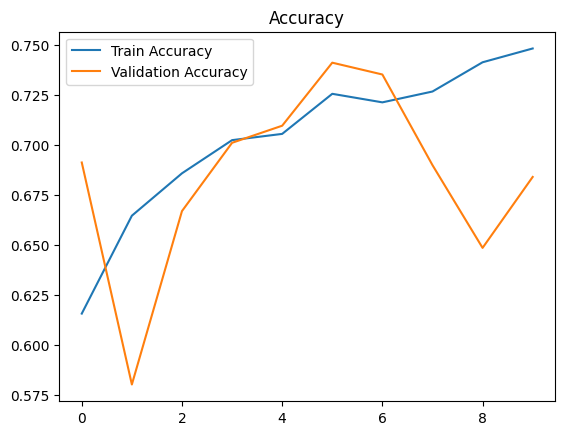

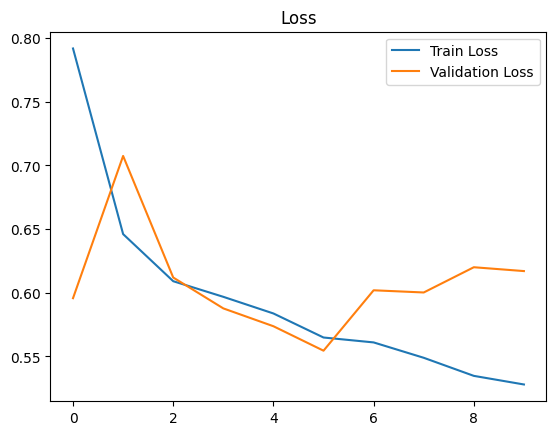

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

# Visualize performance
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Cell 7: Enhanced GUI for Predictions
!pip install -q gradio
import gradio as gr

def predict_gender(image):
    # Preprocess the input image
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img / 255.0, axis=0)
    
    # Predict using the trained model
    pred = model.predict(img)
    pred_label = encoder.inverse_transform([np.argmax(pred)])[0]
    
    return f"Predicted Label: {pred_label}"

# Instructions for the GUI
description = """
This application detects gender based on hair length and age conditions:
- **Ages 20-30**: Gender is predicted based on hair length.
  - Long hair = Female
  - Short hair = Male
- **Below 20 or above 30**: Gender is predicted directly as Male/Female.
Upload an image to see the prediction!
"""

interface = gr.Interface(
    fn=predict_gender,
    inputs=gr.Image(label="Upload an Image"),
    outputs=gr.Textbox(label="Prediction"),
    title="Hair Length and Gender Detection",
    description=description,
)

interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f2faca31a2d597fa76.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
